In [1]:
%matplotlib inline
import sys
import xarray as xr
import numpy as np
import os
import yaml
import math
from datetime import datetime, timedelta
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ParcelsRandom, Variable
import matplotlib.pyplot as plt
from cartopy import crs, feature

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')

from OP_functions import *
import cmocean
cmap = cmocean.cm.deep

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
def get_WW3_path(date):
    """Construct WW3 results path given the date
    e.g., /opp/wwatch3/nowcast/SoG_ww3_fields_YYYYMMDD_YYYYMMDD.nc
    :arg date: date of WW3 record
    :type date: :py:class:`datetime.datetime`
    :returns: WW3 path
    :rtype: str
    """
    # Make WW3 path
    path = '/opp/wwatch3/hindcast'
    path2 = '/opp/wwatch3/nowcast'
    datestr = [date.strftime(fmt) for fmt in ('%d%b%y', '%Y%m%d_%Y%m%d')]
    path = os.path.join(path, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
    if not os.path.exists(path):
        path = os.path.join(path2, datestr[0].lower(), f'SoG_ww3_fields_{datestr[1]}.nc')
        if not os.path.exists(path):    
            raise ValueError(f"No WW3 record found for the specified date {date.strftime('%Y-%b-%d')}")

    return path

In [3]:
path = {'NEMO': '/results2/SalishSea/nowcast-green.202111/',
'coords': '/ocean/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc',
'coordsWW3': '/ocean/jvalenti/MOAD/grid2/WW3_grid.nc',
'mask': '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc',
'bat': '/ocean/jvalenti/MOAD/grid/bathymetry_202108.nc',
'out': '/home/jvalenti/MOAD/results',
'home': '/home/jvalenti/MOAD/analysis-jose/notebooks/parcels',
'anim': '/home/jvalenti/MOAD/animations'}


In [4]:
coords = xr.open_dataset(path['coords'], decode_times=False)
mask = xr.open_dataset(path['mask'])

In [5]:
#Definitions
start = datetime(2022, 8, 23) #Start date
length = 2 # Set Time length [days] 
dt = 90 #toggle between - or + to pick backwards or forwards 
N = 50 # 1000   # number of particles per location
n = 30
dmin = 0 #minimum depth
dd = 40 #max depth difference from dmin
dtp = 0
odt = 1 #mins
rrr = 1e3

In [6]:
#Set deploy coordinates following yaml   
clat = [48.34120226578296, 48.505077276100906]
clon = [ -124.41273653555888,-124.40991436648912]

duration = timedelta(days=length)
#Set deploy locations

clat,clon = transect_deploy(clat,clon,N)

x_offset, y_offset, z = p_deploy(N,n,dmin,dd,rrr)

lon = np.zeros([N,n])
lat = np.zeros([N,n])
for i in range(N):
    lon[i,:]=(clon[i] + x_offset[i,:])
    lat[i,:]=(clat[i] + y_offset[i,:])

In [7]:
#Set start date time and the name of the output file
name = 'Test mixing vs advection'
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile = os.path.join(path['out'], fn)

In [8]:
#Set start date time and the name of the output file
name = 'Test only advection '
daterange = [start+timedelta(days=i) for i in range(length)]
fn =  name + '_'.join(d.strftime('%Y%m%d')+'_1n' for d in [start, start+duration]) + '.zarr'
outfile_nomix = os.path.join(path['out'], fn)

In [9]:
####BUILD FIELDS FOR SIMULATION######
local = 0

varlist=['U','V','W']
filenames,variables=filename_set(start,length,varlist)
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw','time': 'time_counter'}
field_set=FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True, chunksize='auto')

#Find file names and variable names ###'Diat','Flag'###
varlist=['US','VS','WL','R','T','S','ssh','Bathy','Kz','totdepth','Vol']
filenames,variables=filename_set(start,length,varlist)


#Add Vertical diffusivity coefficient field
dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'depthw','time': 'time_counter'}
Kz = Field.from_netcdf(filenames['Kz'], variables['Kz'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Kz)


dimensions = {'lon': 'glamt', 'lat': 'gphit', 'depth': 'deptht','time': 'time_counter'}
R = Field.from_netcdf(filenames['R'], variables['R'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(R)


#Add Bathymetry 2D field
dimensions = {'lon': 'glamt', 'lat': 'gphit'}
Bth = Field.from_netcdf(filenames['Bathy'], variables['Bathy'], dimensions,allow_time_extrapolation=True, chunksize='auto')
TD = Field.from_netcdf(filenames['totdepth'], variables['totdepth'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(Bth)
field_set.add_field(TD)

#Add SSH 
dimensions = {'lon': 'glamt', 'lat': 'gphit','time': 'time_counter'}
SSH = Field.from_netcdf(filenames['ssh'], variables['ssh'], dimensions,allow_time_extrapolation=True, chunksize='auto')
field_set.add_field(SSH)

####BUILD Particle typeN######
class MPParticle(JITParticle):    
    vvl_factor = Variable('fact', initial =  1)    
    wa = Variable('wa', initial =  0) 
    wm = Variable('wm', initial =  0) 
    status = Variable('status', initial =  1) 

In [10]:
pset = ParticleSet.from_list(field_set, MPParticle, lon=lon, lat=lat, depth=z,time=start+timedelta(hours=odt))

In [11]:
def Advection(particle, fieldset, time): 
    if particle.status == 1:
        ssh = fieldset.sossheig[time, particle.depth, particle.lat, particle.lon] #SSH(t)
        sshn = fieldset.sossheig[time+particle.dt, particle.depth, particle.lat, particle.lon] #SSH(t+dt)
        td = fieldset.totaldepth[time, particle.depth, particle.lat, particle.lon]#Total_depth
        particle.fact = (1+ssh/td)
        VVL = (sshn-ssh)*particle.depth/td
        (u1, v1, w1) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon]
        lon1 = particle.lon + u1*.5*particle.dt
        lat1 = particle.lat + v1*.5*particle.dt
        dep1 = particle.depth + w1*.5*particle.dt/particle.fact
        (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1, lat1, lon1]
        lon2 = particle.lon + u2*.5*particle.dt
        lat2 = particle.lat + v2*.5*particle.dt
        dep2 = particle.depth + w2*.5*particle.dt/particle.fact
        (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2, lat2, lon2]
        lon3 = particle.lon + u3*particle.dt
        lat3 = particle.lat + v3*particle.dt
        dep3 = particle.depth + w3*particle.dt/particle.fact
        (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3, lat3, lon3]
        wa = (w1 + 2*w2 + 2*w3 + w4) /6.
        particle.wa = wa* particle.dt
        particle_dlon = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle_dlat = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle_ddepth = particle.wa/particle.fact + VVL
        if particle_ddepth + particle.depth < 0:
            particle_ddepth = - (particle_ddepth+particle.depth)
    else:
        particle_dlon = 0
        particle_dlat = 0
        particle_ddepth = 0

def turb_mix(particle,fieldset,time):
    if particle.status==1:
        """Vertical mixing"""
        #Vertical mixing
        if particle.depth + 0.5/particle.fact > td: #Only calculate gradient of diffusion for particles deeper than 0.5 otherwise OP will check for particles outside the domain and remove it.
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth-0.5/particle.fact, particle.lat, particle.lon]) #backwards difference 
        else: 
            Kzdz = 2*(fieldset.vert_eddy_diff[time, particle.depth+0.5/particle.fact, particle.lat, particle.lon]-fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon]) #forward difference 
        dgrad = Kzdz*particle.dt/particle.fact
        if particle.depth+(0.5*dgrad) > 0 and particle.depth+(0.5*dgrad) < td:
            Kz = fieldset.vert_eddy_diff[time, particle.depth+ 0.5*dgrad, particle.lat, particle.lon] #Vertical diffusivity SSC  
        else:
            Kz = 0#fieldset.vert_eddy_diff[time, particle.depth, particle.lat, particle.lon] 

        Rr = ParcelsRandom.uniform(-1, 1)
        d_random = sqrt(3*2*Kz*particle.dt) * Rr/particle.fact
        dzs = (dgrad + d_random)
        particle.wm = dzs*particle.fact

        deg2met = 111319.5
        latT = 0.6495 
        kh = 1.5 #SSC constant value
        Rrx = ParcelsRandom.uniform(-1, 1)
        Rry = ParcelsRandom.uniform(-1, 1)
        d_x = (sqrt(3*2*kh*particle.dt) * Rrx)/(deg2met*latT)
        d_y = (sqrt(3*2*kh*particle.dt) * Rry)/deg2met   
        d_randomx = particle.lon + d_x + particle_dlon
        d_randomy = particle.lat + d_y + particle_dlat
        Sbh = 1
        Swh = 1
        if particle.depth < 5:
            Sbh = fieldset.sigma_theta[time, 0.51, d_randomy, d_randomx] #Check if particles reach coast at surface (SW Density = 0)
            if Sbh==0:
                print('particle beached')
                particle.status = 2 
        else:
            Swh = fieldset.sigma_theta[time, particle.depth, d_randomy, d_randomx]
            if Swh == 0:
                print('particle hit wall') #Do not cross wall Keep partilce in place
                particle.status = -1


    
def Displacement(particle,fieldset,time):
    '''Apply movement calculated by other kernels'''
    if particle.status==1:
        #Apply turbulent mixing.
        if dzs + particle_ddepth + particle.depth > td: #crossed bottom in dt (Reflect)
            particle_ddepth = 2*td - (dzs + particle_ddepth + 2*particle.depth) #bounce on boundary/ no energy loss
        elif dzs + particle.depth+ particle_ddepth < 0:
            particle_ddepth = -(dzs + particle.depth+particle_ddepth) #reflection on surface
        else:
            particle_ddepth += dzs #apply mixing  

        #Apply horizontal mixing (beaching for particles pushed through coast) 
        if particle.status == 1:
            particle_dlat += d_y
            particle_dlon += d_x
        elif particle.status == -1:
            particle.status = 1 #Do nothing, and resuspend

def export(particle,fieldset,time):
    if particle.status==1:
        test =  -particle.lat*0.84120957 -83.98027258 #Checking if particle gets too close to boundary JdF
        test2 = particle.lon*0.35157547 +90.26497859 #checking southern model boundary
        if particle.lon<test:
            particle.status = 5
        if particle.lat<test2:
            if particle.depth < 5:
                particle.status =2 #beached
                print('beached south')
            else:
                particle_dlat += 0.1*particle.dt/deg2met #northward flow to avoid trapping
        
def CheckOutOfBounds2(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds: 
        particle.delete()

def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:    
        if Sbh == 0: #Ready to beach particles
            print('particle beached')
            particle.state = StatusCode.Success
            particle.status = 2 #beached DO NOT MOVE outside domain
        elif Swh ==0:
            print('particle hit wall') #Do not cross wall Keep partilce in place
            particle.state = StatusCode.Success
            #particle.status = -1 #crossed the wall
        else:
            print('lost Particle')
            particle.status = 10 #lost
            particle.delete()
        
def KeepInOcean(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.depth = 0.0
        particle.state = StatusCode.Success


In [12]:
pset.execute([Advection,turb_mix,Displacement,CheckOutOfBounds,export,KeepInOcean],
            runtime=duration, 
            dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=odt)))

INFO: Output files are stored in /home/jvalenti/MOAD/results/Test mixing vs advection20220823_1n_20220825_1n.zarr.
 51%|█████     | 88200.0/172800.0 [01:39<01:25, 984.26it/s] particle beached
 56%|█████▋    | 97200.0/172800.0 [01:51<01:35, 793.30it/s]particle beached
 62%|██████▎   | 108000.0/172800.0 [02:03<01:22, 788.97it/s]particle hit wall
 84%|████████▍ | 145800.0/172800.0 [02:42<00:24, 1099.59it/s]particle beached
 85%|████████▌ | 147600.0/172800.0 [02:45<00:27, 916.53it/s] particle beached
 95%|█████████▍| 163800.0/172800.0 [03:02<00:08, 1042.80it/s]particle beached
100%|██████████| 172800.0/172800.0 [03:05<00:00, 929.55it/s] 


/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing with an out-of-order index is generating 394 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]
/home/jvalenti/conda_envs/Parcels_24/lib/python3.11/site-packages/xarray/core/indexing.py:1452: PerformanceWarning: Slicing with an out-of-order index is generating 394 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]


Text(0.5, 1.0, 'Particles location at t = 48')

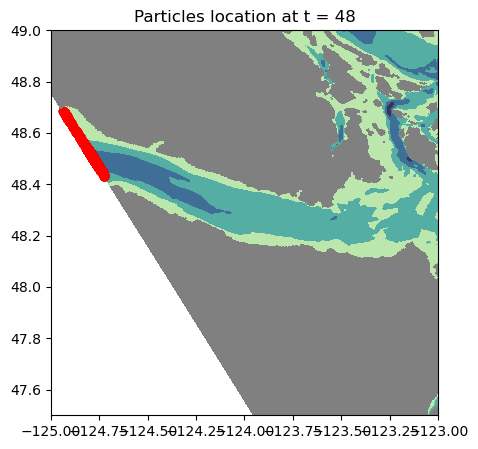

In [28]:
ds = xr.open_zarr(outfile)

# Make map
blevels = list(np.arange(0,500,100))
fig,axs=plt.subplots(1,1,figsize=(5,5))
im=axs.contourf(coords.nav_lon, coords.nav_lat, mask.totaldepth[:,:],zorder=1,cmap=cmap,levels=blevels)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.umask[0,0,:,:],zorder=2,cmap='gray',levels=[-1,0])
plt.scatter(ds.lon[np.where(ds.status==5)][:,-1],ds.lat[np.where(ds.status==5)][:,-1],c='r')
axs.set_ylim([47.5,49])
axs.set_xlim([-125,-123])
axs.set_title(f'Particles location at t = {length*24}')
